生存率、疾病进展和治疗反应

#### 加载必要的库

In [23]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

### 加载数据

In [2]:
# 加载数据集
file_path = 'gse39582_n469_clinical_data.xlsx'
data = pd.read_excel(file_path)

In [3]:
data.head()

,Sample_ID,title,status,submission_date,last_update_date,organism,dataset,sex,age_at_diagnosis_in_years,tnm_stage,...,kras_mutation_dna,kras_mutation_exon_number,kras_mutation_protein,braf_mutation,braf_mutation_dna,braf_mutation_exon_number,braf_mutation_protein,cit_molecular_subtype,CMS,PDS_call
0,GSM971959,CIT003,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Male,36.9,2,...,NaN,NaN,NaN,WT,NaN,NaN,NaN,C3,CMS3,PDS1
1,GSM971962,CIT006,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Male,60.9,3,...,NaN,NaN,NaN,WT,NaN,NaN,NaN,C4,CMS4,PDS2
2,GSM971963,CIT007,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Male,78.2,2,...,NaN,NaN,NaN,WT,NaN,NaN,NaN,C2,CMS1,PDS2
3,GSM971964,CIT008,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Female,35.4,3,...,NaN,NaN,NaN,WT,NaN,NaN,NaN,C1,CMS2,PDS1
4,GSM971965,CIT009,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Female,37.5,2,...,c.35G>A,c.35G>A,p.G12D,WT,NaN,NaN,NaN,C1,UNK,PDS3


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Sample_ID                   469 non-null    object 
 1   title                       469 non-null    object 
 2   status                      469 non-null    object 
 3   submission_date             469 non-null    object 
 4   last_update_date            469 non-null    object 
 5   organism                    469 non-null    object 
 6   dataset                     469 non-null    object 
 7   sex                         469 non-null    object 
 8   age_at_diagnosis_in_years   469 non-null    float64
 9   tnm_stage                   469 non-null    int64  
 10  tnm.t                       449 non-null    object 
 11  tnm.n                       449 non-null    object 
 12  tnm.m                       449 non-null    object 
 13  tumour_location             469 non

<Axes: xlabel='os_event', ylabel='count'>

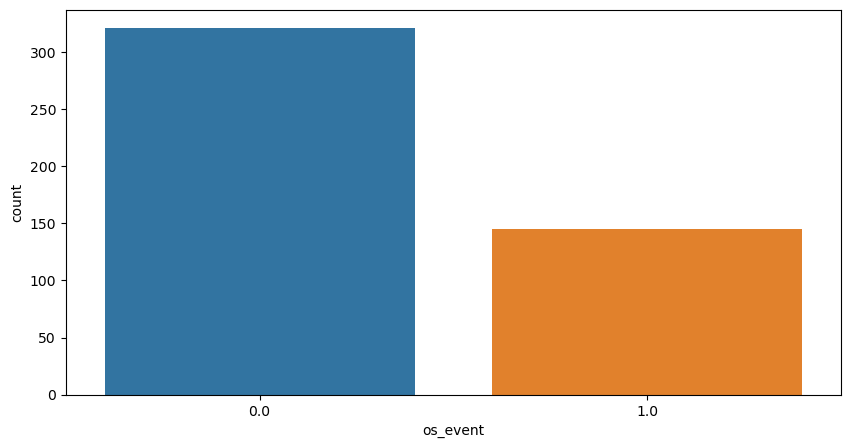

In [15]:
# 设置图的大小
plt.figure(figsize=(10, 5))

# 绘制countplot
sns.countplot(x='os_event', data=data)

In [16]:
# 查看哪些字段有空
data.isnull().sum()

Sample_ID                       0
title                           0
status                          0
submission_date                 0
last_update_date                0
organism                        0
dataset                         0
sex                             0
age_at_diagnosis_in_years       0
tnm_stage                       0
tnm.t                          20
tnm.n                          20
tnm.m                          20
tumour_location                 0
chemotherapy_adjuvant           2
chemotherapy_adjuvant_type    325
rfs_event                       8
rfs_months                      5
os_event                        3
os_months                       3
mmr_status                     45
cimp_status                    67
cin_status                     89
tp53_mutation                 175
tp53_mutation_dna             413
tp53_mutation_exon_number     413
tp53_mutation_protein         415
kras_mutation                  21
kras_mutation_dna             302
kras_mutation_

In [17]:
# 对源数据集进行描述
data.describe(include='all')

,Sample_ID,title,status,submission_date,last_update_date,organism,dataset,sex,age_at_diagnosis_in_years,tnm_stage,...,kras_mutation_dna,kras_mutation_exon_number,kras_mutation_protein,braf_mutation,braf_mutation_dna,braf_mutation_exon_number,braf_mutation_protein,cit_molecular_subtype,CMS,PDS_call
count,469,469,469,469,469,469,469,469,469.000000,469.000000,...,167,167,75,415,20,20,20,469,469,469
unique,469,469,1,1,1,1,2,2,NaN,NaN,...,22,22,13,2,1,1,1,6,5,4
top,GSM971959,CIT003,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Male,NaN,NaN,...,EX2.codon12,EX2.codon12,p.G12D,WT,c.1799T>A,c.1799T>A,p.V600E,C5,CMS2,PDS1
freq,1,1,469,469,469,469,362,261,NaN,NaN,...,44,44,30,372,20,20,20,125,161,150
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.668230,2.437100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.991864,0.496558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# 对数据集进行清理
data.dropna(subset=['rfs_event', 'rfs_months', 'os_event', 'os_months'], inplace=True)

In [19]:
# 查看哪些字段有空
data.isnull().sum()

Sample_ID                       0
title                           0
status                          0
submission_date                 0
last_update_date                0
organism                        0
dataset                         0
sex                             0
age_at_diagnosis_in_years       0
tnm_stage                       0
tnm.t                          20
tnm.n                          20
tnm.m                          20
tumour_location                 0
chemotherapy_adjuvant           1
chemotherapy_adjuvant_type    318
rfs_event                       0
rfs_months                      0
os_event                        0
os_months                       0
mmr_status                     44
cimp_status                    67
cin_status                     89
tp53_mutation                 173
tp53_mutation_dna             405
tp53_mutation_exon_number     405
tp53_mutation_protein         407
kras_mutation                  21
kras_mutation_dna             297
kras_mutation_

### 构建特征

#### 1. 生存率

In [20]:
Target = ['os_event']

In [21]:
data_columns_survival = ['rfs_event', 'rfs_months', 'os_months']

In [22]:
columns_survival = Target + data_columns_survival

In [45]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data[data_columns_survival], 
                                                                    data[Target], 
                                                                    random_state=0)

In [25]:
X_train.shape

(345, 3)

In [26]:
y_train.shape

(345, 1)

In [46]:
X_test.shape

(116, 3)

In [28]:
y_test.shape

(116, 1)

### 随机森林算法

In [47]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

In [48]:
rf = RandomForestClassifier(random_state=1,
                            n_jobs=-1)

In [31]:
param_gird = {
    'criterion':['gini', 'entropy'],
    'min_samples_leaf':[1, 5, 10],
    'min_samples_split':[2, 4, 10, 12, 16],
    'n_estimators': [50, 100, 400, 700, 1000]
}

In [32]:
gs = GridSearchCV(estimator=rf,
                  param_grid=param_gird,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

In [33]:
gs = gs.fit(X_train, y_train)

/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

In [34]:
print(gs.best_score_)

0.7913043478260869


In [35]:
print(gs.best_params_)

{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 50}


In [36]:
# 创建一个对象
rf2 = RandomForestClassifier(criterion='gini',
                            min_samples_leaf=5,
                            min_samples_split=16,
                            n_estimators=50,
                            n_jobs=-1,
                            random_state=1)

In [37]:
rf2.fit(X_train, y_train)

/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_leaf=5, min_samples_split=16,
                       n_estimators=50, n_jobs=-1, random_state=1)

In [38]:
# 预测
# 根据特征的重要性排序
pd.concat((pd.DataFrame(X_train.iloc[:, 1:].columns, columns=['Variable']),
           pd.DataFrame(rf2.feature_importances_, columns=['importance'])),
           axis=1).sort_values(by='importance', ascending=False)

,Variable,importance
1,os_months,0.401701
2,NaN,0.327724
0,rfs_months,0.270575


 #### 在test上进行预测

In [49]:
pred = rf2.predict(X_test)

In [50]:
pred_df = pd.DataFrame(pred, columns=['os_event'])

In [51]:
pred_df.head()

,os_event
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0


Accuracy: 0.87
ROC AUC: 0.81


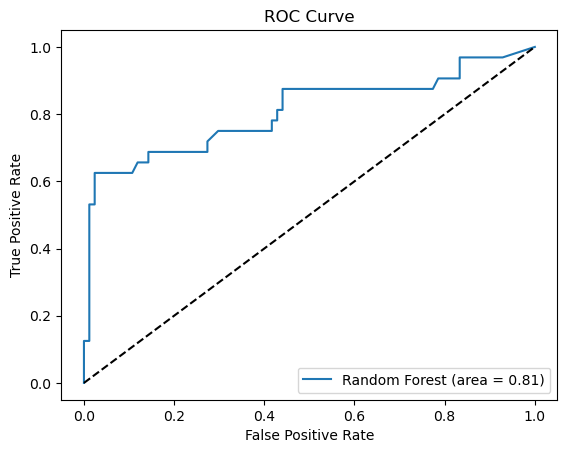

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 假设rf2是已经训练好的模型，X_test是测试特征，y_test是测试标签

# 使用模型预测测试集的概率
y_pred_proba = rf2.predict_proba(X_test)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, rf2.predict(X_test))
print(f'Accuracy: {accuracy:.2f}')

# 计算AUC值
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.2f}')

# 生成ROC曲线的值：fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角虚线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


-----

In [52]:
# 保存模型
model_filename = 'survival_rate_model.pkl'
joblib.dump(rf2, model_filename)

['survival_rate_model.pkl']